In [1]:
%%time

# importing necessary dependencies
import json
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import seaborn
import plotly.express as px
import csv
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm.notebook import tqdm
import warnings
from IPython.display import clear_output

CPU times: total: 2.14 s
Wall time: 27.8 s


In [2]:
%%time
# Code for calculating ESG scores and RRI scores using incidents 

# calculate time weights
n_years = 2
n_days = 365*n_years
curvature_ = 1
weights = np.arange(1,n_days + 1)
weights = weights/weights.max()
weights = ((2**weights) - 1)**curvature_
time_weights = pd.Series(weights)

# calculate raw score for each incident
def get_raw_scores(id_, data, col='score'):
    try:
        incidents = data[data['ISIN'] == id_]
        incidents.set_index('date', inplace=True)
        incident_scores = incidents[col]
        score = incident_scores.rolling(n_days).apply(lambda scores: np.dot(scores, time_weights)).fillna(0)
        return score
    except Exception as e:
        print("error occured", e)

# scale scores
def scale(series, lambda_=0.000105, curvature=5.3):
    return 100*((1 - np.exp(-lambda_*series))**(1/curvature))

scaling = scale(pd.Series(range(750)))
# reduce score importance based on time
def max_decay(series, decay=0.5**(1/365)):
    new_series = pd.Series(index=series.index, dtype="float")
    previous = 0
    for date, value in series.items():
        if previous > 0:
            if value/previous < decay:
                new_series[date] = previous*decay
            else:
                new_series[date] = value
        else:
            new_series[date] = value
            
        previous = new_series[date]
    return new_series


CPU times: total: 0 ns
Wall time: 7.51 ms


### S&P500

In [ ]:
%%time
esg_data_spx = {} # store all esg data for stocks
nodata_spx = set()

s = set(incident_data['ISIN']).intersection(all_isinSPX)

for isin in tqdm(all_isinSPX): # for each isin value
    if isin in esg_data_spx:
        continue
    else:
        try:
            scores = incident_data[incident_data['ISIN'] == isin] # find dataset corresponding to isin
            
            esg_metrics = {'ISIN': scores['ISIN'].values, 'date': scores['date'].values, 'price': scores['price'].values} # get isin, date, prices
            
            esgx = ['environmental', 'social', 'governance']
            for subscore in esgx: # calculate each subscore
                scores[subscore + '_score'] = np.where(scores['incident_count'] != 0, scores['score']*scores[subscore]/scores['incident_count'], 0)
                esg_metrics[subscore] = max_decay(scale(get_raw_scores(isin, scores, subscore + '_score'))).values
            esg_metrics['esg_score'] = max_decay(scale(get_raw_scores(isin, incident_data, 'score')))
            esg_data_spx[isin] = pd.DataFrame(esg_metrics) # create dataframe for each subscore
            esg_data_spx[isin].set_index('date', inplace=True)
        except Exception as e:
            print(e)
            print(isin)
            nodata_spx.add(isin)

# isin values for which there is no data
for isin in all_isinSPX:
    if isin not in set(incident_data['ISIN']):
        nodata_spx.add(isin)

In [3]:
%%time
# read datafile that contains all incidents and prices for all isins
incident_data = pd.read_csv("PAPER3_DATA_v1.0.csv", quoting=csv.QUOTE_NONE)

# columns of the dataset
incident_data.columns = ['num', 'ISIN', 'date', 'price', 'ID_RR', 'isBND', 'incident_count', 'unsharp', 
                'severity', 'reach', 'novelty', 'environmental', 'social', 'governance']

for key in ['num', 'ISIN']:
    incident_data[key] = incident_data[key].str.replace('\"', '')

incident_data = incident_data.dropna()

incident_data['date'] = pd.to_datetime(incident_data['date'])

# calculate score
incident_data['score'] = np.where(incident_data['incident_count'] != 0, 
                         10**((incident_data['severity'] / incident_data['incident_count']) - 1) * 
                         (incident_data['reach'] / incident_data['incident_count']) * 
                         (incident_data['novelty'] / incident_data['incident_count']), 
                         0)

# read all constituents in S&P500
spx_const = pd.read_csv("historical.constituents_SPX.csv", quoting=csv.QUOTE_NONE)

spx_const.columns = ["count", "ISIN", "date", "Index_SPX"]
for key in ["count", "ISIN"]:
    spx_const[key] = spx_const[key].str.replace('\"', '')

spx_constituents = {}

# map each date to respective S&P500 constituents
for i in tqdm(range(len(spx_const))):
    row = spx_const.iloc[i]
    if not spx_constituents.get(row['date']):
        spx_constituents[row['date']] = set()
    spx_constituents[row['date']].add(row['ISIN'])

all_isinSPX = set() # set of all isins ever in the S&P500
for date in spx_constituents.keys():
    all_isinSPX = all_isinSPX.union(spx_constituents[date])
all_isinSPX.remove('')

# read stock prices using fundamental data
stock_prices = pd.read_csv("esg_data/spx_TR.CLOSEPRICE.csv", quoting=csv.QUOTE_NONE)

stock_prices.columns = ['num', 'isin', 'close', 'date']

for key in ['num', 'isin', 'close', 'date']:
    stock_prices[key] = stock_prices[key].str.replace('\"', '')
    
stock_prices = stock_prices.replace(r'^\s*$', np.nan, regex=True)
stock_prices = stock_prices.dropna()
stock_prices['close'] =  pd.to_numeric(stock_prices['close'])
stock_prices['date'] = stock_prices['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
stock_prices.set_index('isin', inplace=True)
stock_prices = stock_prices.drop('num', axis=1)

# Convert to a 2D dictionary (isin -> date -> row)
stock_prices['isin2'] = stock_prices.index
stock_prices = stock_prices.groupby('isin2').apply(
    lambda x: x.set_index('date').drop(columns='isin2').to_dict('index')
).to_dict()


# read already stored esg data for equities
with open('data.json') as json_file:
    esg_data_spx = json.load(json_file)

for isin in tqdm(esg_data_spx):
    esg_data_spx[isin] = pd.DataFrame.from_dict(esg_data_spx[isin])

# sector data
sector_data = pd.read_csv("SPsectors.csv", quoting=csv.QUOTE_NONE)
spx_sector = {sector_data['ISIN'].iloc[i]: sector_data['SP_sectors'].iloc[i] for i in range(len(sector_data))}

<timed exec>:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.


  0%|          | 0/4962660 [00:00<?, ?it/s]

<timed exec>:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


  0%|          | 0/1197 [00:00<?, ?it/s]

CPU times: total: 5min 21s
Wall time: 11min 16s


In [4]:
# isin values for which there is no given sector
no_sectors = set()
for isin in all_isinSPX:
    if spx_sector.get(isin, 'random') not in ['communications', 'consumer_discretionary', 'consumer_staples', 'energy', 'financials', 'health_care', 'industrials', 'information_technology', 'materials',  'real_estate', 'utilities']:
        no_sectors.add(isin)
print(f"There are {len(no_sectors)} companies with no assigned sector.")

There are 180 companies with no assigned sector.


In [17]:
import investpy
for isin in no_sectors:
    try:
        print(investpy.stocks.search_stocks(by='isin', value=isin).full_name[0])
    except Exception:
        pass

Lockheed Martin Corp
General Dynamics Corp
People’s United Financial Inc
Raytheon Company
Huntington Ingalls Industries Inc
Unilever NV ADR
L3Harris Technologies Inc
Textron Inc
Transdigm Group Incorporated
SunTrust Banks Inc
Northrop Grumman Corp
Boeing Company
FLIR Systems Inc


  0%|          | 0/505 [00:00<?, ?it/s]



ESG scores for equities distribution on 2022-03-16:


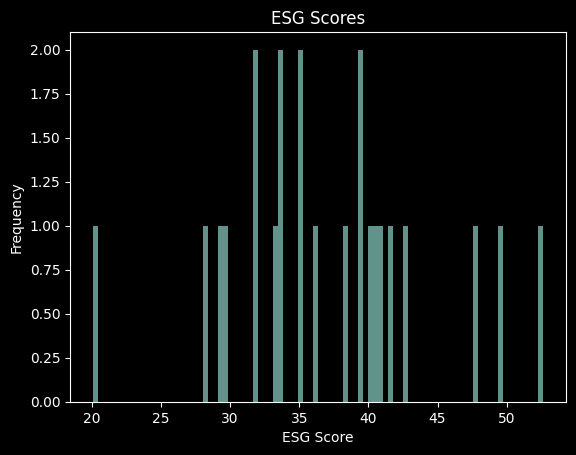

Total count: 23
Standard deviation: 7.2
Max score: 52.66
Median: 36.3
Mean (Excluding 0): 37.0
Q1: 32.67
Q3: 40.66
IQR: 7.99


In [41]:

# check if there are any isins for which there is no data for a given date
date = '2022-03-16'
date2 = date.replace('-', '/')
scores = []
dates = []
companies = []
na = set()
for isin in tqdm(spx_constituents[date]):
    if spx_sector.get(isin, '') != "utilities":
        continue
    try:
        scores.append([esg_data_spx[isin][esg_data_spx[isin].index > date2]['esg_score'].iloc[0], isin])
        dates.append(esg_data_spx[isin][esg_data_spx[isin].index > date2].index[0])
        companies.append(isin)
    except Exception:
        na.add(isin)
scores.sort()


plt.style.use('dark_background') # plot distribution of ESG scores for given date

print(f"\n\nESG scores for equities distribution on {date}:")
n, bins, patches = plt.hist([x[0] for x in scores], bins=90, linewidth=0.5, alpha=0.7)
plt.title('ESG Scores', fontsize=12)
plt.xlabel('ESG Score', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

# descriptive statistics for distribution
arr = np.array([x[0] for x in scores])
print(f"Total count: {len(scores)}")
print(f"Standard deviation: {round(np.std(arr), 2)}")
print(f"Max score: {round(max(arr), 2)}")
print(f"Median: {round(np.median(arr), 2)}")
print(f"Mean (Excluding 0): {round(arr[arr != 0].mean(), 2)}")
print(f"Q1: {round(np.percentile(arr, 25), 2)}")
print(f"Q3: {round(np.percentile(arr, 75), 2)}")
print(f"IQR: {round(np.subtract(*np.percentile(arr, [75, 25])), 2)}")

In [42]:
# 5 companies with best ESG score
for rri, isin in scores[:5]:
    try:
        print(investpy.stocks.search_stocks(by='isin', value=isin).full_name[0])
    except Exception:
        print(isin)

American Water Works
Eversource Energy
Nextera Energy Inc
PPL Corporation
Alliant Energy Corp


In [43]:
# 5 companies with highest ESG score (bad)
for rri, isin in scores[-5:]:
    print(investpy.stocks.search_stocks(by='isin', value=isin).full_name[0])

Edison International
Dominion Energy Inc
Duke Energy Corporation
FirstEnergy Corporation
Sempra Energy


In [6]:
# dates to start tracking from 2022-03-19 to 15 years back weekly on wednesday
datelist = [datetime.strptime('2022-03-16', '%Y-%m-%d') - timedelta(days=x*7) for x in range(780)]
datelist.reverse()

no_data = {}  # ISIN from S&P500 for which no data is available
sp500_data = {}  # S&P500 Data with ESG scores for which is available

for date_obj in tqdm(datelist):
    date = date_obj.strftime('%Y/%m/%d')
    no_data[date] = set()
    sp500_data[date] = {}
    for isin in spx_constituents[date.replace('/', '-')]:
        try:
            if not esg_data_spx[isin][esg_data_spx[isin].index == date].empty:
                sp500_data[date][isin] = esg_data_spx[isin][esg_data_spx[isin].index == date].copy()
                try:
                    # Replace prices with fundamental data prices from Marc Weibel
                    price = stock_prices.loc[(stock_prices.index == isin) & (stock_prices['date'] == pd.to_datetime(date)), 'close'].values[0]
                    sp500_data[date][isin].loc[:, 'price'] = price
                except Exception:
                    pass
            else:
                no_data[date].add(isin)
        except Exception:
            no_data[date].add(isin)


  0%|          | 0/780 [00:00<?, ?it/s]

In [7]:
print(esg_data_spx['US88160R1014'][-361:-359]) # Prices are not adjusted for splits? TSLA split was later though
print('\nUsing Fundamental Data:\n')
print(pd.DataFrame(stock_prices['US88160R1014']).transpose()['close'][-484:-482])

                    ISIN       price  environmental     social  governance  \
2022/05/20  US88160R1014  442.599889      43.749010  59.194743   46.811620   
2022/05/23  US88160R1014  224.966442      43.723339  59.164048   46.782111   

            esg_score  
2022/05/20  62.881388  
2022/05/23  62.848611  

Using Fundamental Data:

2022-05-20    221.299779
2022-05-23    224.966442
Name: close, dtype: float64


In [8]:
for isin in tqdm(all_isinSPX):
    for i in range(len(datelist)):
        date = datelist[i].strftime('%Y/%m/%d') 
        try:
            esg_data_spx[isin][esg_data_spx[isin].index <= date]['price'] = sp500_data[date][isin]['price']
        except Exception:
            pass

  0%|          | 0/1197 [00:00<?, ?it/s]

C:\Users\anish\AppData\Local\Temp\ipykernel_13244\2609983365.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esg_data_spx[isin][esg_data_spx[isin].index <= date]['price'] = sp500_data[date][isin]['price']


  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1414997017.py:52: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] > THRESHOLD).bool(): # if esg metric is greater than threshold add it to non esg portfolios
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1414997017.py:55: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] == 0).bool(): # if esg metric is zero add to non_esg_zero portfolio
  0%|                                                                                               | 1/780 [00:00<05:35,  2.32it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1414997017.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the futu

<Figure size 640x480 with 0 Axes>

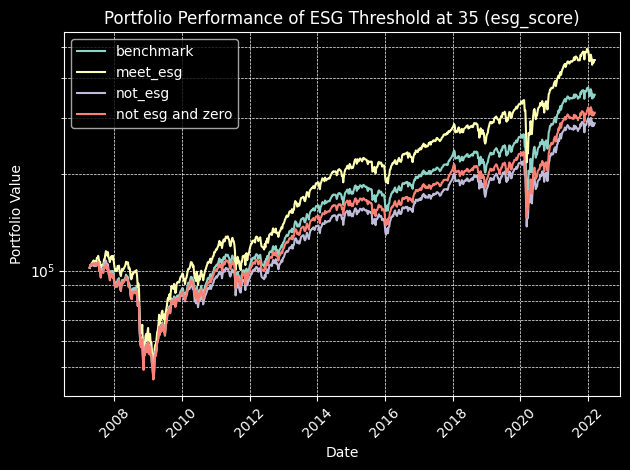


ESG Portfolio Metrics
Sharpe Ratio: 0.428
Average Return (Per Annum): 1.105
Final Value: 456355.014


Non-ESG Portfolio Metrics
Sharpe Ratio: 0.289
Average Return (Per Annum): 1.072
Final Value: 289074.507


Non-ESG/0-RRI Portfolio Metrics
Sharpe Ratio: 0.308
Average Return (Per Annum): 1.077
Final Value: 312072.538


Benchmark Portfolio Metrics
Sharpe Ratio: 0.351
Average Return (Per Annum): 1.087
Final Value: 355358.701



  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1414997017.py:52: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] > THRESHOLD).bool(): # if esg metric is greater than threshold add it to non esg portfolios
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1414997017.py:55: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] == 0).bool(): # if esg metric is zero add to non_esg_zero portfolio
  0%|                                                                                               | 1/780 [00:00<04:34,  2.84it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1414997017.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the futu

<Figure size 640x480 with 0 Axes>

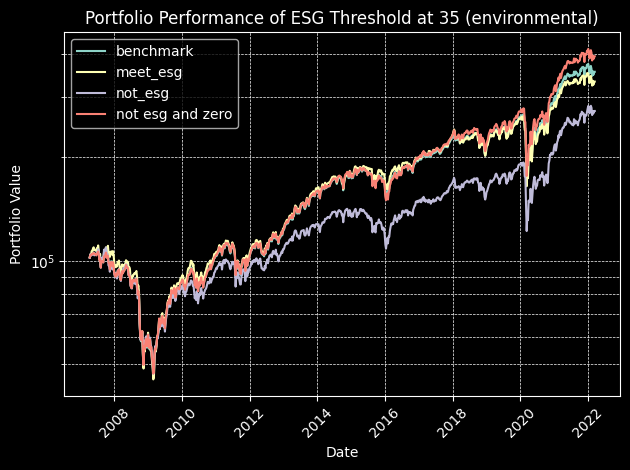


ESG Portfolio Metrics
Sharpe Ratio: 0.318
Average Return (Per Annum): 1.082
Final Value: 332760.603


Non-ESG Portfolio Metrics
Sharpe Ratio: 0.266
Average Return (Per Annum): 1.068
Final Value: 273221.261


Non-ESG/0-RRI Portfolio Metrics
Sharpe Ratio: 0.39
Average Return (Per Annum): 1.094
Final Value: 394251.181


Benchmark Portfolio Metrics
Sharpe Ratio: 0.351
Average Return (Per Annum): 1.087
Final Value: 355358.701



  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1414997017.py:52: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] > THRESHOLD).bool(): # if esg metric is greater than threshold add it to non esg portfolios
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1414997017.py:55: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] == 0).bool(): # if esg metric is zero add to non_esg_zero portfolio
  0%|                                                                                               | 1/780 [00:00<03:19,  3.90it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1414997017.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the futu

<Figure size 640x480 with 0 Axes>

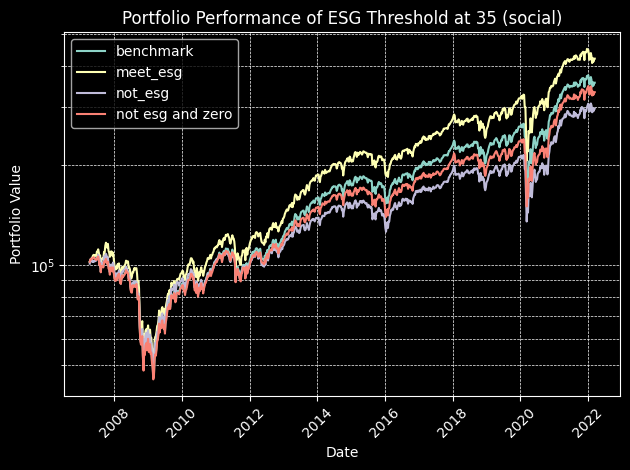


ESG Portfolio Metrics
Sharpe Ratio: 0.412
Average Return (Per Annum): 1.099
Final Value: 420005.878


Non-ESG Portfolio Metrics
Sharpe Ratio: 0.3
Average Return (Per Annum): 1.075
Final Value: 296962.708


Non-ESG/0-RRI Portfolio Metrics
Sharpe Ratio: 0.324
Average Return (Per Annum): 1.082
Final Value: 332726.191


Benchmark Portfolio Metrics
Sharpe Ratio: 0.351
Average Return (Per Annum): 1.087
Final Value: 355358.701



  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1414997017.py:52: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] > THRESHOLD).bool(): # if esg metric is greater than threshold add it to non esg portfolios
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1414997017.py:55: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] == 0).bool(): # if esg metric is zero add to non_esg_zero portfolio
  0%|                                                                                               | 1/780 [00:00<02:17,  5.65it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1414997017.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the futu

<Figure size 640x480 with 0 Axes>

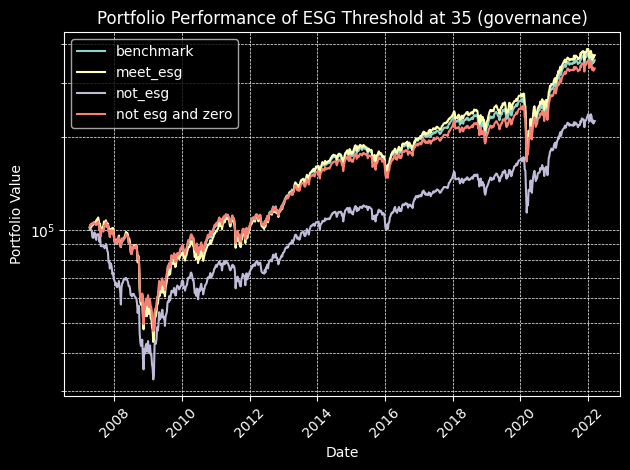


ESG Portfolio Metrics
Sharpe Ratio: 0.355
Average Return (Per Annum): 1.09
Final Value: 369097.722


Non-ESG Portfolio Metrics
Sharpe Ratio: 0.191
Average Return (Per Annum): 1.056
Final Value: 225634.168


Non-ESG/0-RRI Portfolio Metrics
Sharpe Ratio: 0.338
Average Return (Per Annum): 1.082
Final Value: 334210.577


Benchmark Portfolio Metrics
Sharpe Ratio: 0.351
Average Return (Per Annum): 1.087
Final Value: 355358.701



In [117]:
datelist = [datetime.strptime('2022-03-16', '%Y-%m-%d') - timedelta(days=x*7) for x in range(780)]
datelist.reverse()

THRESHOLD = 35 # fixed threshold for RRI score
PERCENTILE = 0.3 # top 30 percent companies in terms of ESG performance

# spx sectors
SECTORS = ['communications', 'consumer_discretionary', 'consumer_staples', 'energy', 'financials', 'health_care', 
           'industrials', 'information_technology', 'materials',  'real_estate', 'utilities']

# which metric to look at
METRICS = ['esg_score', 'environmental', 'social', 'governance']

# meet_esg - companies meeting esg criteria and RRI not zero
# not_esg - companies not meeting esg criteria and RRI not zero
# not_esg_zero - not_esg + companies with rri of 0
OPTIONS = ['meet_esg', 'not_esg', 'not_esg_zero', 'benchmark']

# all isins in S&P500 for given date
def generate_isin(date):
    return sp500_data[date]
# all isins in specific sector in S&P500 for given date
# def generate_isin(date, sector):
#     isin_values = set()
#     for isin in sp500_data[date]:
#         if spx_sector.get(isin, '') == sector:
#             isin_values.add(isin)
#     return isin_values

for metric in METRICS:
    portfolios = {x: {'account_value': 100000, 'holdings': {}, 'history': []} for x in OPTIONS}

    for i in tqdm(range(len(datelist))):
        # parse current date
        date = datelist[i].strftime('%Y/%m/%d') 
    
        # sell all holdings of current date for each portfolio
        for x in OPTIONS:
            # sell each holding at last available price
            for isin in portfolios[x]['holdings']:
                portfolios[x]['account_value'] += float(portfolios[x]['holdings'][isin] * esg_data_spx[isin][esg_data_spx[isin].index <= date].iloc[-1]['price'])
            
            # clear all holdings
            portfolios[x]['holdings'] = {}
            
            # add new value to portfolio history
            portfolios[x]['history'].append(portfolios[x]['account_value'])
            
        for isin in generate_isin(date): # generate all isins to consider investing
            if sp500_data[date][isin].empty: # if no data ignore
                continue
            elif (sp500_data[date][isin][metric] > THRESHOLD).bool(): # if esg metric is greater than threshold add it to non esg portfolios
                portfolios['not_esg']['holdings'][isin] = 0
                portfolios['not_esg_zero']['holdings'][isin] = 0
            elif (sp500_data[date][isin][metric] == 0).bool(): # if esg metric is zero add to non_esg_zero portfolio
                portfolios['not_esg_zero']['holdings'][isin] = 0
            else: # add other investments to portfolio that meets esg metric requirements
                portfolios['meet_esg']['holdings'][isin] = 0
            portfolios['benchmark']['holdings'][isin] = 0 # benchmark portfolio
    
        for x in OPTIONS:
            cnt = len(portfolios[x]['holdings']) # number of holdings 
            if cnt == 0: continue
            val = portfolios[x]['account_value'] / cnt # value allocated to each investment // CURRENTLY USING EQUAL WEIGHTED WILL CHANGE TO MARKET CAP TOO
            
            # determine number of shares for each isin
            for isin in portfolios[x]['holdings']:
                portfolios[x]['holdings'][isin] = val/sp500_data[date][isin]['price']
                portfolios[x]['account_value'] -= val
    
    # sell everything at the end
    for x in OPTIONS:
        # sell each holding at last available price
        for isin in portfolios[x]['holdings']:
            portfolios[x]['account_value'] += float(portfolios[x]['holdings'][isin] * esg_data_spx[isin][esg_data_spx[isin].index <= date].iloc[-1]['price'])
        
        # clear all holdings
        portfolios[x]['holdings'] = {}
        
        # add new value to portfolio history
        portfolios[x]['history'].append(portfolios[x]['account_value'])
        portfolios[x]['history'] = portfolios[x]['history'][1:]

    
    # Set dark theme
    plt.clf()
    plt.style.use('dark_background')
    fig, ax = plt.subplots()
    
    # Plot data
    ax.plot(datelist, portfolios['benchmark']['history'], label='benchmark', linestyle='-')
    ax.plot(datelist, portfolios['meet_esg']['history'], label='meet_esg', linestyle='-')
    ax.plot(datelist, portfolios['not_esg']['history'], label='not_esg', linestyle='-')
    ax.plot(datelist, portfolios['not_esg_zero']['history'], label='not esg and zero', linestyle='-')
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value')
    ax.set_title(f'Portfolio Performance of ESG Threshold at 35 ({metric})')
    plt.yscale("log")   
    plt.xticks(rotation=45)
    ax.legend()
    ax.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    def rd(x):
        return round(x, 3) 
        
    # Calculate sharpe ratio and returns
    def portfolioMetrics(history):
        risk_free_rate = 0.015
        annual_return = (history[-1]/history[0])**(1/(len(history)/52)) - 1
        annual_std = np.array([(history[i] - history[i - 1])/history[i - 1] for i in range(1, len(history))]).std() * np.sqrt(52)
        print(f"Sharpe Ratio: {rd((annual_return - risk_free_rate)/annual_std)}")
        print(f"Average Return (Per Annum): {rd(((history[-1]/history[0])**(1/len(history)))**52)}")
        print(f"Final Value: {rd(history[-1])}\n")
    
    # Display Metrics
    print("\n\033[4mESG Portfolio Metrics\033[0m")
    portfolioMetrics(portfolios['meet_esg']['history'])
    print("\n\033[4mNon-ESG Portfolio Metrics\033[0m")
    portfolioMetrics(portfolios['not_esg']['history'])
    print("\n\033[4mNon-ESG/0-RRI Portfolio Metrics\033[0m")
    portfolioMetrics(portfolios['not_esg_zero']['history'])
    print("\n\033[4mBenchmark Portfolio Metrics\033[0m")
    portfolioMetrics(portfolios['benchmark']['history'])

  0%|          | 0/260 [00:00<?, ?it/s]

C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3910714300.py:52: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] > THRESHOLD).bool(): # if esg metric is greater than threshold add it to non esg portfolios
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3910714300.py:55: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] == 0).bool(): # if esg metric is zero add to non_esg_zero portfolio
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3910714300.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  portfolios[x]['account_value'] += float(portfolios[x]['holdings'][isin] * esg_data_spx[isin][esg_data_spx[isin].index <= date].iloc[-1]['price'])
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3910714300.py:75: FutureWarning

<Figure size 640x480 with 0 Axes>

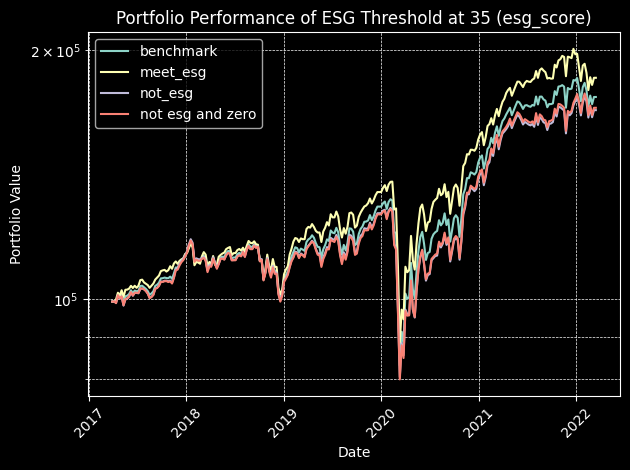


ESG Portfolio Metrics
Sharpe Ratio: 0.563
Average Return (Per Annum): 1.133
Final Value: 185311.463


Non-ESG Portfolio Metrics
Sharpe Ratio: 0.467
Average Return (Per Annum): 1.113
Final Value: 169345.204


Non-ESG/0-RRI Portfolio Metrics
Sharpe Ratio: 0.471
Average Return (Per Annum): 1.114
Final Value: 170453.089


Benchmark Portfolio Metrics
Sharpe Ratio: 0.507
Average Return (Per Annum): 1.121
Final Value: 175661.823



  0%|          | 0/260 [00:00<?, ?it/s]

C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3910714300.py:52: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] > THRESHOLD).bool(): # if esg metric is greater than threshold add it to non esg portfolios
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3910714300.py:55: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] == 0).bool(): # if esg metric is zero add to non_esg_zero portfolio
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3910714300.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  portfolios[x]['account_value'] += float(portfolios[x]['holdings'][isin] * esg_data_spx[isin][esg_data_spx[isin].index <= date].iloc[-1]['price'])
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3910714300.py:75: FutureWarning

<Figure size 640x480 with 0 Axes>

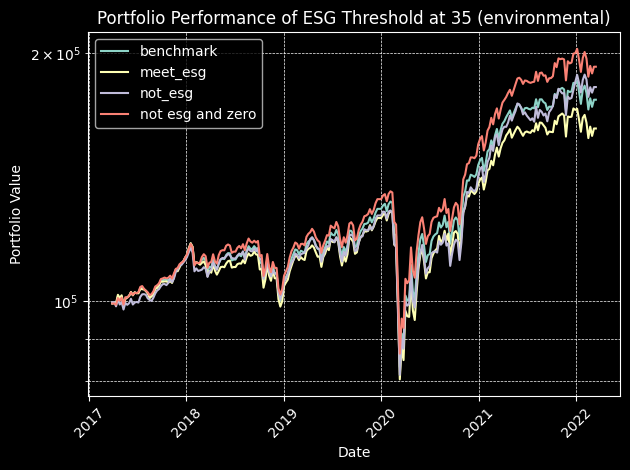


ESG Portfolio Metrics
Sharpe Ratio: 0.416
Average Return (Per Annum): 1.103
Final Value: 162082.595


Non-ESG Portfolio Metrics
Sharpe Ratio: 0.55
Average Return (Per Annum): 1.128
Final Value: 182000.436


Non-ESG/0-RRI Portfolio Metrics
Sharpe Ratio: 0.612
Average Return (Per Annum): 1.142
Final Value: 192647.672


Benchmark Portfolio Metrics
Sharpe Ratio: 0.507
Average Return (Per Annum): 1.121
Final Value: 175661.823



  0%|          | 0/260 [00:00<?, ?it/s]

C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3910714300.py:52: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] > THRESHOLD).bool(): # if esg metric is greater than threshold add it to non esg portfolios
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3910714300.py:55: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] == 0).bool(): # if esg metric is zero add to non_esg_zero portfolio
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3910714300.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  portfolios[x]['account_value'] += float(portfolios[x]['holdings'][isin] * esg_data_spx[isin][esg_data_spx[isin].index <= date].iloc[-1]['price'])
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3910714300.py:75: FutureWarning

<Figure size 640x480 with 0 Axes>

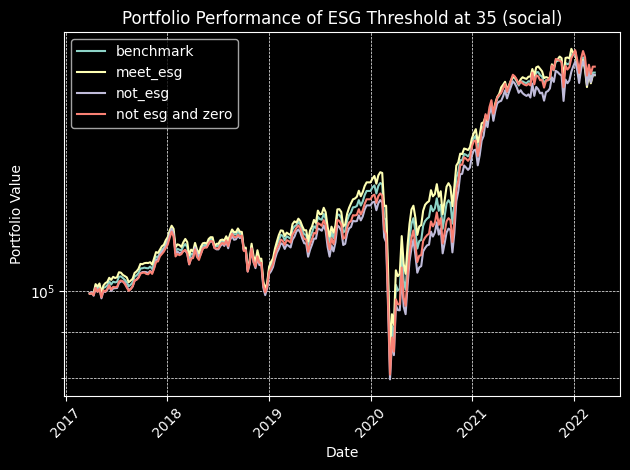


ESG Portfolio Metrics
Sharpe Ratio: 0.501
Average Return (Per Annum): 1.119
Final Value: 174454.655


Non-ESG Portfolio Metrics
Sharpe Ratio: 0.494
Average Return (Per Annum): 1.119
Final Value: 174637.851


Non-ESG/0-RRI Portfolio Metrics
Sharpe Ratio: 0.516
Average Return (Per Annum): 1.124
Final Value: 178371.124


Benchmark Portfolio Metrics
Sharpe Ratio: 0.507
Average Return (Per Annum): 1.121
Final Value: 175661.823



  0%|          | 0/260 [00:00<?, ?it/s]

C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3910714300.py:52: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] > THRESHOLD).bool(): # if esg metric is greater than threshold add it to non esg portfolios
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3910714300.py:55: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] == 0).bool(): # if esg metric is zero add to non_esg_zero portfolio
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3910714300.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  portfolios[x]['account_value'] += float(portfolios[x]['holdings'][isin] * esg_data_spx[isin][esg_data_spx[isin].index <= date].iloc[-1]['price'])
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3910714300.py:75: FutureWarning

<Figure size 640x480 with 0 Axes>

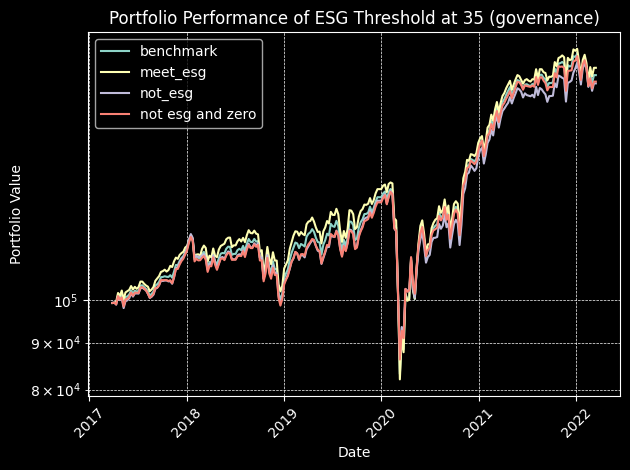


ESG Portfolio Metrics
Sharpe Ratio: 0.499
Average Return (Per Annum): 1.125
Final Value: 178911.731


Non-ESG Portfolio Metrics
Sharpe Ratio: 0.53
Average Return (Per Annum): 1.116
Final Value: 172071.236


Non-ESG/0-RRI Portfolio Metrics
Sharpe Ratio: 0.53
Average Return (Per Annum): 1.117
Final Value: 172835.355


Benchmark Portfolio Metrics
Sharpe Ratio: 0.507
Average Return (Per Annum): 1.121
Final Value: 175661.823



In [132]:
datelist = [datetime.strptime('2022-03-16', '%Y-%m-%d') - timedelta(days=x*7) for x in range(260)]
datelist.reverse()

THRESHOLD = 35 # fixed threshold for RRI score
PERCENTILE = 0.3 # top 30 percent companies in terms of ESG performance

# spx sectors
SECTORS = ['communications', 'consumer_discretionary', 'consumer_staples', 'energy', 'financials', 'health_care', 
           'industrials', 'information_technology', 'materials',  'real_estate', 'utilities']

# which metric to look at
METRICS = ['esg_score', 'environmental', 'social', 'governance']

# meet_esg - companies meeting esg criteria and RRI not zero
# not_esg - companies not meeting esg criteria and RRI not zero
# not_esg_zero - not_esg + companies with rri of 0
OPTIONS = ['meet_esg', 'not_esg', 'not_esg_zero', 'benchmark']

# all isins in S&P500 for given date
def generate_isin(date):
    return sp500_data[date]
# all isins in specific sector in S&P500 for given date
# def generate_isin(date, sector):
#     isin_values = set()
#     for isin in sp500_data[date]:
#         if spx_sector.get(isin, '') == sector:
#             isin_values.add(isin)
#     return isin_values

for metric in METRICS:
    portfolios = {x: {'account_value': 100000, 'holdings': {}, 'history': []} for x in OPTIONS}

    for i in tqdm(range(len(datelist))):
        # parse current date
        date = datelist[i].strftime('%Y/%m/%d') 
    
        # sell all holdings of current date for each portfolio
        for x in OPTIONS:
            # sell each holding at last available price
            for isin in portfolios[x]['holdings']:
                portfolios[x]['account_value'] += float(portfolios[x]['holdings'][isin] * esg_data_spx[isin][esg_data_spx[isin].index <= date].iloc[-1]['price'])
            
            # clear all holdings
            portfolios[x]['holdings'] = {}
            
            # add new value to portfolio history
            portfolios[x]['history'].append(portfolios[x]['account_value'])
            
        for isin in generate_isin(date): # generate all isins to consider investing
            if sp500_data[date][isin].empty: # if no data ignore
                continue
            elif (sp500_data[date][isin][metric] > THRESHOLD).bool(): # if esg metric is greater than threshold add it to non esg portfolios
                portfolios['not_esg']['holdings'][isin] = 0
                portfolios['not_esg_zero']['holdings'][isin] = 0
            elif (sp500_data[date][isin][metric] == 0).bool(): # if esg metric is zero add to non_esg_zero portfolio
                portfolios['not_esg_zero']['holdings'][isin] = 0
            else: # add other investments to portfolio that meets esg metric requirements
                portfolios['meet_esg']['holdings'][isin] = 0
            portfolios['benchmark']['holdings'][isin] = 0 # benchmark portfolio
    
        for x in OPTIONS:
            cnt = len(portfolios[x]['holdings']) # number of holdings 
            if cnt == 0: continue
            val = portfolios[x]['account_value'] / cnt # value allocated to each investment // CURRENTLY USING EQUAL WEIGHTED WILL CHANGE TO MARKET CAP TOO
            
            # determine number of shares for each isin
            for isin in portfolios[x]['holdings']:
                portfolios[x]['holdings'][isin] = val/sp500_data[date][isin]['price']
                portfolios[x]['account_value'] -= val
    
    # sell everything at the end
    for x in OPTIONS:
        # sell each holding at last available price
        for isin in portfolios[x]['holdings']:
            portfolios[x]['account_value'] += float(portfolios[x]['holdings'][isin] * esg_data_spx[isin][esg_data_spx[isin].index <= date].iloc[-1]['price'])
        
        # clear all holdings
        portfolios[x]['holdings'] = {}
        
        # add new value to portfolio history
        portfolios[x]['history'].append(portfolios[x]['account_value'])
        portfolios[x]['history'] = portfolios[x]['history'][1:]

    
    # Set dark theme
    plt.clf()
    plt.style.use('dark_background')
    fig, ax = plt.subplots()
    
    # Plot data
    ax.plot(datelist, portfolios['benchmark']['history'], label='benchmark', linestyle='-')
    ax.plot(datelist, portfolios['meet_esg']['history'], label='meet_esg', linestyle='-')
    ax.plot(datelist, portfolios['not_esg']['history'], label='not_esg', linestyle='-')
    ax.plot(datelist, portfolios['not_esg_zero']['history'], label='not esg and zero', linestyle='-')
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value')
    ax.set_title(f'Portfolio Performance of ESG Threshold at 35 ({metric})')
    plt.yscale("log")   
    plt.xticks(rotation=45)
    ax.legend()
    ax.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    def rd(x):
        return round(x, 3) 
        
    # Calculate sharpe ratio and returns
    def portfolioMetrics(history):
        risk_free_rate = 0.015
        annual_return = (history[-1]/history[0])**(1/(len(history)/52)) - 1
        annual_std = np.array([(history[i] - history[i - 1])/history[i - 1] for i in range(1, len(history))]).std() * np.sqrt(52)
        print(f"Sharpe Ratio: {rd((annual_return - risk_free_rate)/annual_std)}")
        print(f"Average Return (Per Annum): {rd(((history[-1]/history[0])**(1/len(history)))**52)}")
        print(f"Final Value: {rd(history[-1])}\n")
    
    # Display Metrics
    print("\n\033[4mESG Portfolio Metrics\033[0m")
    portfolioMetrics(portfolios['meet_esg']['history'])
    print("\n\033[4mNon-ESG Portfolio Metrics\033[0m")
    portfolioMetrics(portfolios['not_esg']['history'])
    print("\n\033[4mNon-ESG/0-RRI Portfolio Metrics\033[0m")
    portfolioMetrics(portfolios['not_esg_zero']['history'])
    print("\n\033[4mBenchmark Portfolio Metrics\033[0m")
    portfolioMetrics(portfolios['benchmark']['history'])

  0%|          | 0/520 [00:00<?, ?it/s]

C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3659636334.py:52: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] > THRESHOLD).bool(): # if esg metric is greater than threshold add it to non esg portfolios
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3659636334.py:55: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] == 0).bool(): # if esg metric is zero add to non_esg_zero portfolio
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3659636334.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  portfolios[x]['account_value'] += float(portfolios[x]['holdings'][isin] * esg_data_spx[isin][esg_data_spx[isin].index <= date].iloc[-1]['price'])
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3659636334.py:75: FutureWarning

<Figure size 640x480 with 0 Axes>

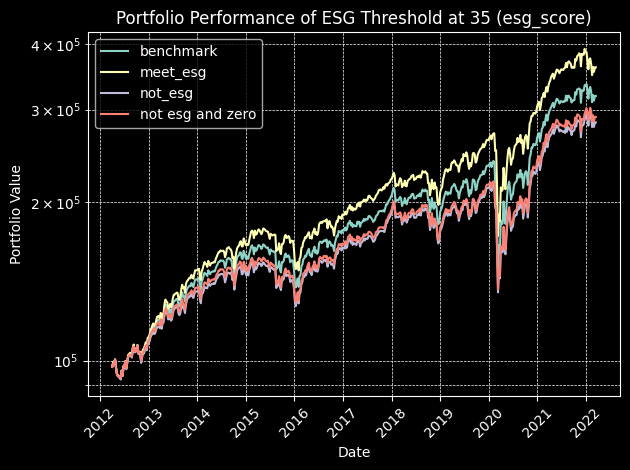


ESG Portfolio Metrics
Sharpe Ratio: 0.713
Average Return (Per Annum): 1.139
Final Value: 361101.736


Non-ESG Portfolio Metrics
Sharpe Ratio: 0.57
Average Return (Per Annum): 1.113
Final Value: 283694.167


Non-ESG/0-RRI Portfolio Metrics
Sharpe Ratio: 0.58
Average Return (Per Annum): 1.116
Final Value: 290605.057


Benchmark Portfolio Metrics
Sharpe Ratio: 0.64
Average Return (Per Annum): 1.126
Final Value: 318477.856



  0%|          | 0/520 [00:00<?, ?it/s]

C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3659636334.py:52: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] > THRESHOLD).bool(): # if esg metric is greater than threshold add it to non esg portfolios
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3659636334.py:55: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] == 0).bool(): # if esg metric is zero add to non_esg_zero portfolio
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3659636334.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  portfolios[x]['account_value'] += float(portfolios[x]['holdings'][isin] * esg_data_spx[isin][esg_data_spx[isin].index <= date].iloc[-1]['price'])
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3659636334.py:75: FutureWarning

<Figure size 640x480 with 0 Axes>

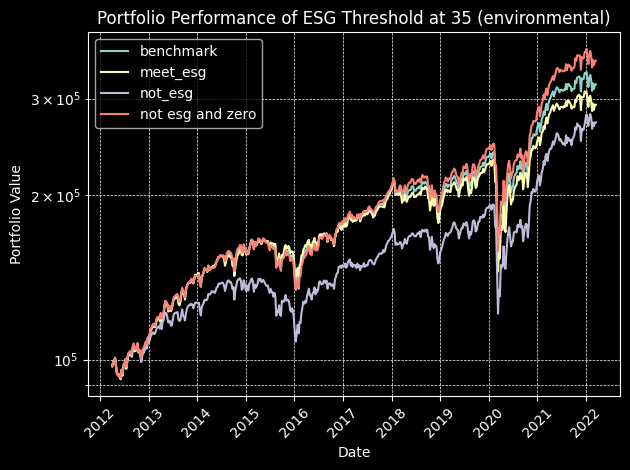


ESG Portfolio Metrics
Sharpe Ratio: 0.58
Average Return (Per Annum): 1.116
Final Value: 292317.073


Non-ESG Portfolio Metrics
Sharpe Ratio: 0.536
Average Return (Per Annum): 1.108
Final Value: 271412.292


Non-ESG/0-RRI Portfolio Metrics
Sharpe Ratio: 0.705
Average Return (Per Annum): 1.137
Final Value: 351769.142


Benchmark Portfolio Metrics
Sharpe Ratio: 0.64
Average Return (Per Annum): 1.126
Final Value: 318477.856



  0%|          | 0/520 [00:00<?, ?it/s]

C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3659636334.py:52: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] > THRESHOLD).bool(): # if esg metric is greater than threshold add it to non esg portfolios
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3659636334.py:55: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] == 0).bool(): # if esg metric is zero add to non_esg_zero portfolio
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3659636334.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  portfolios[x]['account_value'] += float(portfolios[x]['holdings'][isin] * esg_data_spx[isin][esg_data_spx[isin].index <= date].iloc[-1]['price'])
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3659636334.py:75: FutureWarning

<Figure size 640x480 with 0 Axes>

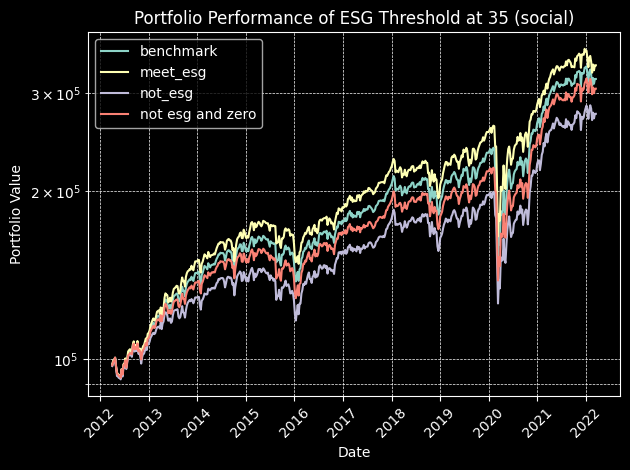


ESG Portfolio Metrics
Sharpe Ratio: 0.675
Average Return (Per Annum): 1.132
Final Value: 337017.954


Non-ESG Portfolio Metrics
Sharpe Ratio: 0.545
Average Return (Per Annum): 1.11
Final Value: 275690.773


Non-ESG/0-RRI Portfolio Metrics
Sharpe Ratio: 0.607
Average Return (Per Annum): 1.121
Final Value: 305934.586


Benchmark Portfolio Metrics
Sharpe Ratio: 0.64
Average Return (Per Annum): 1.126
Final Value: 318477.856



  0%|          | 0/520 [00:00<?, ?it/s]

C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3659636334.py:52: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] > THRESHOLD).bool(): # if esg metric is greater than threshold add it to non esg portfolios
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3659636334.py:55: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] == 0).bool(): # if esg metric is zero add to non_esg_zero portfolio
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3659636334.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  portfolios[x]['account_value'] += float(portfolios[x]['holdings'][isin] * esg_data_spx[isin][esg_data_spx[isin].index <= date].iloc[-1]['price'])
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\3659636334.py:75: FutureWarning

<Figure size 640x480 with 0 Axes>

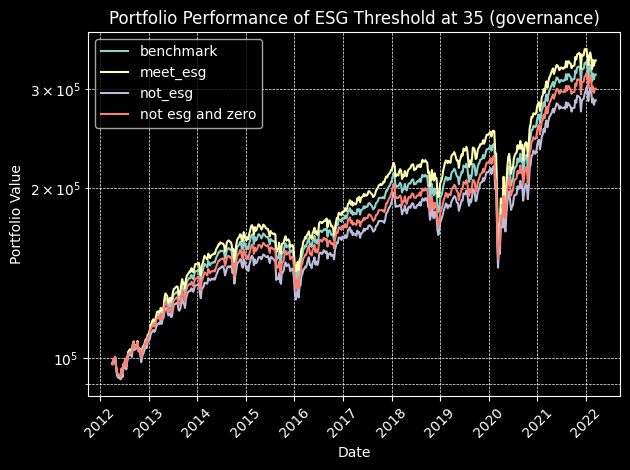


ESG Portfolio Metrics
Sharpe Ratio: 0.652
Average Return (Per Annum): 1.132
Final Value: 337284.268


Non-ESG Portfolio Metrics
Sharpe Ratio: 0.611
Average Return (Per Annum): 1.114
Final Value: 286601.163


Non-ESG/0-RRI Portfolio Metrics
Sharpe Ratio: 0.634
Average Return (Per Annum): 1.119
Final Value: 300504.621


Benchmark Portfolio Metrics
Sharpe Ratio: 0.64
Average Return (Per Annum): 1.126
Final Value: 318477.856



In [133]:
datelist = [datetime.strptime('2022-03-16', '%Y-%m-%d') - timedelta(days=x*7) for x in range(520)]
datelist.reverse()

THRESHOLD = 35 # fixed threshold for RRI score
PERCENTILE = 0.3 # top 30 percent companies in terms of ESG performance

# spx sectors
SECTORS = ['communications', 'consumer_discretionary', 'consumer_staples', 'energy', 'financials', 'health_care', 
           'industrials', 'information_technology', 'materials',  'real_estate', 'utilities']

# which metric to look at
METRICS = ['esg_score', 'environmental', 'social', 'governance']

# meet_esg - companies meeting esg criteria and RRI not zero
# not_esg - companies not meeting esg criteria and RRI not zero
# not_esg_zero - not_esg + companies with rri of 0
OPTIONS = ['meet_esg', 'not_esg', 'not_esg_zero', 'benchmark']

# all isins in S&P500 for given date
def generate_isin(date):
    return sp500_data[date]
# all isins in specific sector in S&P500 for given date
# def generate_isin(date, sector):
#     isin_values = set()
#     for isin in sp500_data[date]:
#         if spx_sector.get(isin, '') == sector:
#             isin_values.add(isin)
#     return isin_values

for metric in METRICS:
    portfolios = {x: {'account_value': 100000, 'holdings': {}, 'history': []} for x in OPTIONS}

    for i in tqdm(range(len(datelist))):
        # parse current date
        date = datelist[i].strftime('%Y/%m/%d') 
    
        # sell all holdings of current date for each portfolio
        for x in OPTIONS:
            # sell each holding at last available price
            for isin in portfolios[x]['holdings']:
                portfolios[x]['account_value'] += float(portfolios[x]['holdings'][isin] * esg_data_spx[isin][esg_data_spx[isin].index <= date].iloc[-1]['price'])
            
            # clear all holdings
            portfolios[x]['holdings'] = {}
            
            # add new value to portfolio history
            portfolios[x]['history'].append(portfolios[x]['account_value'])
            
        for isin in generate_isin(date): # generate all isins to consider investing
            if sp500_data[date][isin].empty: # if no data ignore
                continue
            elif (sp500_data[date][isin][metric] > THRESHOLD).bool(): # if esg metric is greater than threshold add it to non esg portfolios
                portfolios['not_esg']['holdings'][isin] = 0
                portfolios['not_esg_zero']['holdings'][isin] = 0
            elif (sp500_data[date][isin][metric] == 0).bool(): # if esg metric is zero add to non_esg_zero portfolio
                portfolios['not_esg_zero']['holdings'][isin] = 0
            else: # add other investments to portfolio that meets esg metric requirements
                portfolios['meet_esg']['holdings'][isin] = 0
            portfolios['benchmark']['holdings'][isin] = 0 # benchmark portfolio
    
        for x in OPTIONS:
            cnt = len(portfolios[x]['holdings']) # number of holdings 
            if cnt == 0: continue
            val = portfolios[x]['account_value'] / cnt # value allocated to each investment // CURRENTLY USING EQUAL WEIGHTED WILL CHANGE TO MARKET CAP TOO
            
            # determine number of shares for each isin
            for isin in portfolios[x]['holdings']:
                portfolios[x]['holdings'][isin] = val/sp500_data[date][isin]['price']
                portfolios[x]['account_value'] -= val
    
    # sell everything at the end
    for x in OPTIONS:
        # sell each holding at last available price
        for isin in portfolios[x]['holdings']:
            portfolios[x]['account_value'] += float(portfolios[x]['holdings'][isin] * esg_data_spx[isin][esg_data_spx[isin].index <= date].iloc[-1]['price'])
        
        # clear all holdings
        portfolios[x]['holdings'] = {}
        
        # add new value to portfolio history
        portfolios[x]['history'].append(portfolios[x]['account_value'])
        portfolios[x]['history'] = portfolios[x]['history'][1:]

    
    # Set dark theme
    plt.clf()
    plt.style.use('dark_background')
    fig, ax = plt.subplots()
    
    # Plot data
    ax.plot(datelist, portfolios['benchmark']['history'], label='benchmark', linestyle='-')
    ax.plot(datelist, portfolios['meet_esg']['history'], label='meet_esg', linestyle='-')
    ax.plot(datelist, portfolios['not_esg']['history'], label='not_esg', linestyle='-')
    ax.plot(datelist, portfolios['not_esg_zero']['history'], label='not esg and zero', linestyle='-')
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value')
    ax.set_title(f'Portfolio Performance of ESG Threshold at 35 ({metric})')
    plt.yscale("log")   
    plt.xticks(rotation=45)
    ax.legend()
    ax.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    def rd(x):
        return round(x, 3) 
        
    # Calculate sharpe ratio and returns
    def portfolioMetrics(history):
        risk_free_rate = 0.015
        annual_return = (history[-1]/history[0])**(1/(len(history)/52)) - 1
        annual_std = np.array([(history[i] - history[i - 1])/history[i - 1] for i in range(1, len(history))]).std() * np.sqrt(52)
        print(f"Sharpe Ratio: {rd((annual_return - risk_free_rate)/annual_std)}")
        print(f"Average Return (Per Annum): {rd(((history[-1]/history[0])**(1/len(history)))**52)}")
        print(f"Final Value: {rd(history[-1])}\n")
    
    # Display Metrics
    print("\n\033[4mESG Portfolio Metrics\033[0m")
    portfolioMetrics(portfolios['meet_esg']['history'])
    print("\n\033[4mNon-ESG Portfolio Metrics\033[0m")
    portfolioMetrics(portfolios['not_esg']['history'])
    print("\n\033[4mNon-ESG/0-RRI Portfolio Metrics\033[0m")
    portfolioMetrics(portfolios['not_esg_zero']['history'])
    print("\n\033[4mBenchmark Portfolio Metrics\033[0m")
    portfolioMetrics(portfolios['benchmark']['history'])

  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1343075271.py:10: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  if (sp500_data[date][isin]['environmental'] > 0).bool() and (sp500_data[date][isin]['social'] > 0).bool() and (sp500_data[date][isin]['governance'] > 0).bool():
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 780/780 [01:07<00:00, 11.55it/s]


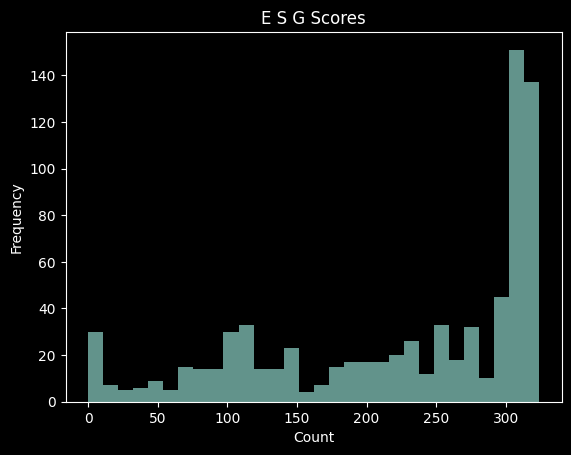

  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1343075271.py:29: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  if (sp500_data[date][isin]['environmental'] > 0).bool() and (sp500_data[date][isin]['social'] > 0).bool():
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 780/780 [00:45<00:00, 17.23it/s]


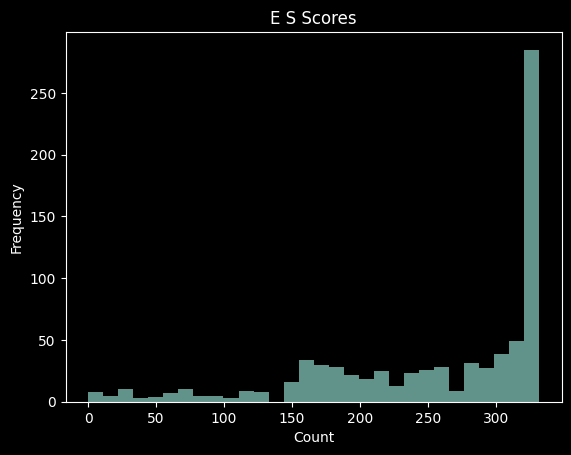

  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1343075271.py:47: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  if (sp500_data[date][isin]['environmental'] > 0).bool() and (sp500_data[date][isin]['governance'] > 0).bool():
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 780/780 [00:48<00:00, 16.19it/s]


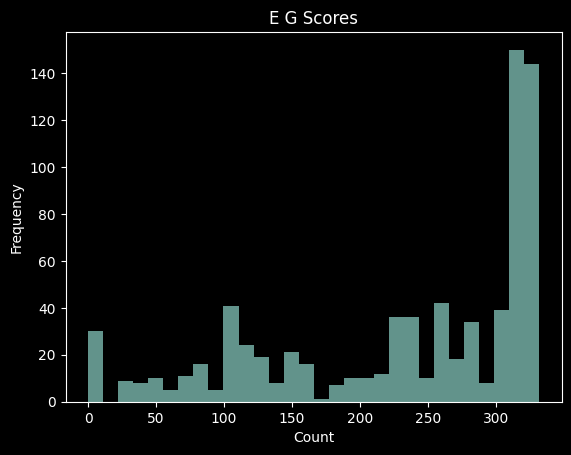

  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1343075271.py:65: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  if (sp500_data[date][isin]['governance'] > 0).bool() and (sp500_data[date][isin]['social'] > 0).bool():
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 780/780 [00:51<00:00, 15.13it/s]


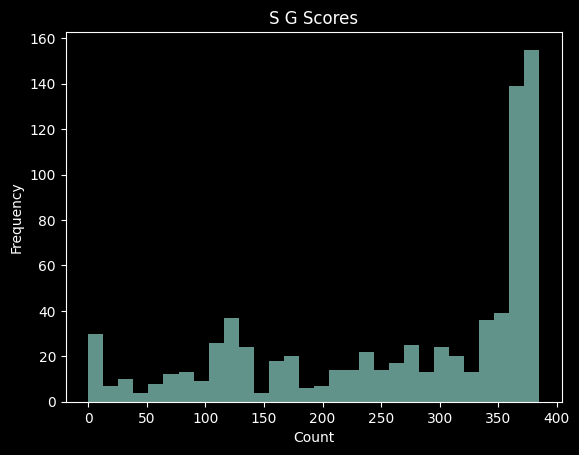

  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1343075271.py:83: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  if (sp500_data[date][isin]['environmental'] > 0).bool():
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 780/780 [00:32<00:00, 24.28it/s]


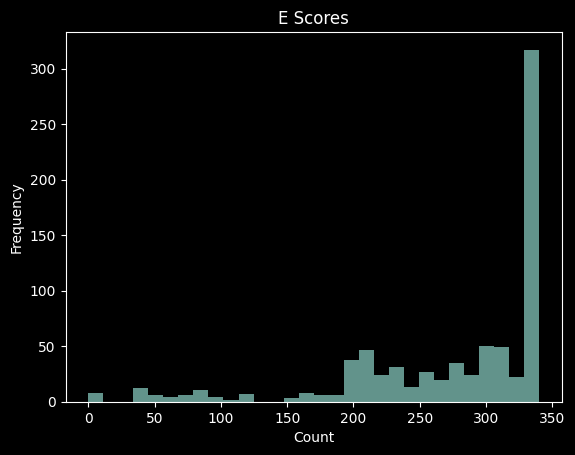

  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1343075271.py:101: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  if (sp500_data[date][isin]['social'] > 0).bool():
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 780/780 [00:32<00:00, 23.95it/s]


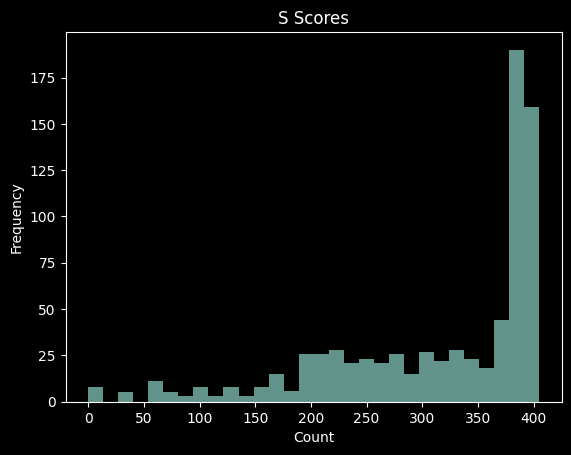

  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1343075271.py:119: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  if (sp500_data[date][isin]['governance'] > 0).bool():
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 780/780 [00:42<00:00, 18.55it/s]


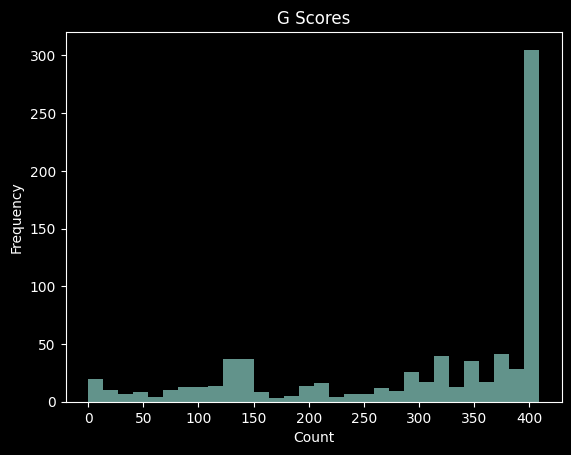

In [104]:
# counts of companies out of 500 who have an ESG score of more than 0
counts = []
for i in tqdm(range(len(datelist))):
    # parse current date
    date = datelist[i].strftime('%Y/%m/%d') 
    cnt = 0
    for isin in generate_isin(date): # generate all isins to consider investing
        if sp500_data[date][isin].empty: # if no data ignore
            continue
        if (sp500_data[date][isin]['environmental'] > 0).bool() and (sp500_data[date][isin]['social'] > 0).bool() and (sp500_data[date][isin]['governance'] > 0).bool():
            cnt += 1
    counts.append(cnt)

n, bins, patches = plt.hist(counts, bins=30, linewidth=0.5, alpha=0.7)
plt.title('E S G Scores', fontsize=12)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

# counts of companies out of 500 who have an ESG score of more than 0
counts = []
for i in tqdm(range(len(datelist))):
    # parse current date
    date = datelist[i].strftime('%Y/%m/%d') 
    cnt = 0
    for isin in generate_isin(date): # generate all isins to consider investing
        if sp500_data[date][isin].empty: # if no data ignore
            continue
        if (sp500_data[date][isin]['environmental'] > 0).bool() and (sp500_data[date][isin]['social'] > 0).bool():
            cnt += 1
    counts.append(cnt)

n, bins, patches = plt.hist(counts, bins=30, linewidth=0.5, alpha=0.7)
plt.title('E S Scores', fontsize=12)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

counts = []
for i in tqdm(range(len(datelist))):
    # parse current date
    date = datelist[i].strftime('%Y/%m/%d') 
    cnt = 0
    for isin in generate_isin(date): # generate all isins to consider investing
        if sp500_data[date][isin].empty: # if no data ignore
            continue
        if (sp500_data[date][isin]['environmental'] > 0).bool() and (sp500_data[date][isin]['governance'] > 0).bool():
            cnt += 1
    counts.append(cnt)

n, bins, patches = plt.hist(counts, bins=30, linewidth=0.5, alpha=0.7)
plt.title('E G Scores', fontsize=12)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

counts = []
for i in tqdm(range(len(datelist))):
    # parse current date
    date = datelist[i].strftime('%Y/%m/%d') 
    cnt = 0
    for isin in generate_isin(date): # generate all isins to consider investing
        if sp500_data[date][isin].empty: # if no data ignore
            continue
        if (sp500_data[date][isin]['governance'] > 0).bool() and (sp500_data[date][isin]['social'] > 0).bool():
            cnt += 1
    counts.append(cnt)

n, bins, patches = plt.hist(counts, bins=30, linewidth=0.5, alpha=0.7)
plt.title('S G Scores', fontsize=12)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

counts = []
for i in tqdm(range(len(datelist))):
    # parse current date
    date = datelist[i].strftime('%Y/%m/%d') 
    cnt = 0
    for isin in generate_isin(date): # generate all isins to consider investing
        if sp500_data[date][isin].empty: # if no data ignore
            continue
        if (sp500_data[date][isin]['environmental'] > 0).bool():
            cnt += 1
    counts.append(cnt)

n, bins, patches = plt.hist(counts, bins=30, linewidth=0.5, alpha=0.7)
plt.title('E Scores', fontsize=12)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

counts = []
for i in tqdm(range(len(datelist))):
    # parse current date
    date = datelist[i].strftime('%Y/%m/%d') 
    cnt = 0
    for isin in generate_isin(date): # generate all isins to consider investing
        if sp500_data[date][isin].empty: # if no data ignore
            continue
        if (sp500_data[date][isin]['social'] > 0).bool():
            cnt += 1
    counts.append(cnt)

n, bins, patches = plt.hist(counts, bins=30, linewidth=0.5, alpha=0.7)
plt.title('S Scores', fontsize=12)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

counts = []
for i in tqdm(range(len(datelist))):
    # parse current date
    date = datelist[i].strftime('%Y/%m/%d') 
    cnt = 0
    for isin in generate_isin(date): # generate all isins to consider investing
        if sp500_data[date][isin].empty: # if no data ignore
            continue
        if (sp500_data[date][isin]['governance'] > 0).bool():
            cnt += 1
    counts.append(cnt)

n, bins, patches = plt.hist(counts, bins=30, linewidth=0.5, alpha=0.7)
plt.title('G Scores', fontsize=12)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

### Eurostoxx

### US Bonds

In [44]:
# FILE = "bond_data/historical.constituents_iBoxx_USD_HIGH_YIELD_COMPONENTS.csv"
FILE = "bond_data/historical.constituents_iBoxx_USD_INVESTMENT_GRADE_COMPONENTS.csv" # bond dtta US investment grade location
# FILE = "bond_data/historical.constituents_iBoxx_EUR_HIGH_YIELD_COMPONENTS.csv"

df = pd.read_csv(FILE, quoting=csv.QUOTE_NONE) # convert to pandas dataframe

df.columns = ['date', 'isin', 'index_weight', 'bid_price', 'ask_price']

for key in ['date', 'isin', 'index_weight', 'bid_price', 'ask_price']:
    df[key] = df[key].str.replace('\"', '')
    if key not in {'date', 'isin'}:
        df[key] = df[key].astype(float)

df = df.dropna()

df['date'] = pd.to_datetime(df['date']) # set date as datetime object and make it the index
df.set_index('date', inplace=True)
bonds = {} # dictionary for bond constituents for each date
for date in set(df.index):
    bonds[date] = df[df.index == date]

dates = sorted(list(set(df.index))) # sort given dates (monthly)


bond_data = {} # store esg scores and prices for each bond ISIN
nodata = set()

# read already stored esg data for equities
with open('data.json') as json_file:
    bond_data = json.load(json_file)

for isin in tqdm(esg_data_spx):
    bond_data[isin] = pd.DataFrame.from_dict(bond_data[isin])

  0%|          | 0/1197 [00:00<?, ?it/s]

In [ ]:
for isin in tqdm(set(df['isin']).intersection(set(incident_data['ISIN']))): # for each isin value
    if len(bond_data.get(isin, [])):
        continue
    try:
        scores = incident_data[incident_data['ISIN'] == isin] # find dataset corresponding to isin
        
        esg_metrics = {'ISIN': scores['ISIN'].values, 'date': scores['date'].values, 'price': scores['price'].values} # get isin, date, prices
        
        esgx = ['environmental', 'social', 'governance']
        for subscore in esgx: # calculate each subscore
            scores[subscore + '_score'] = np.where(scores['incident_count'] != 0, scores['score']*scores[subscore]/scores['incident_count'], 0)
            esg_metrics[subscore] = max_decay(scale(get_raw_scores(isin, scores, subscore + '_score'))).values
        esg_metrics['esg_score'] = max_decay(scale(get_raw_scores(isin, incident_data, 'score')))
        bond_data[isin] = pd.DataFrame(esg_metrics) # create dataframe for each subscore
        bond_data[isin].set_index('date', inplace=True)
    except Exception as e:
        print(e)
        print(isin)
        nodata.add(isin)

# save data to json file

!pip install ujson
import ujson

exportData = {}

for isin in tqdm(bond_data.keys()):
    df = bond_data[isin]
    df.index = pd.to_datetime(df.index).strftime('%Y/%m/%d')
    exportData[isin] = df.to_dict('dict')

file_path = 'bond_data.json'

with open(file_path, 'w') as json_file:
    ujson.dump(exportData, json_file, indent=4)

print(f"Data has been saved to {file_path}")

### Euro Bonds